In [ ]:
from nbdev import *
%nbdev_default_export cell_data
%reload_ext autoreload
%autoreload 2

Cells will be exported to wtlike.cell_data,
unless a different module is specified after an export flag: `%nbdev_export special.module`


# Manage cell data
> Create cells from source data

In [ ]:
%nbdev_export
import os
import numpy as np
import pandas as pd
from wtlike.config import *
from wtlike.source_data import *
from wtlike.loglike import LogLike, PoissonRep

In [ ]:
%nbdev_export
class CellData(SourceData):
    """Manage a set of cells generated from a data set
    
        Invoke superclass to load photon data and exposure for the source.
 
        * time_bins, default config.time_bins
        
        
        Note that the `e`  cell entry is the actual exposure for the cell in units $cm^2\ s$, times $10^{-6}$.
        """
    
    def __init__(self, *pars, **kwargs): 
        """

        """
        bins = kwargs.pop('bins', kwargs.pop('time_bins', Config().time_bins))
        #  load source data
        super().__init__(*pars, **kwargs )
        self.use_uint8  = self.config.use_uint8
        
        self.exp_totexposure_factor=1e-6
        self.rebin(bins)

    def rebin(self, newbins):
        """bin, or rebin 
        """
        photon_data = self.photons
        self.cell_edges = edges = time_bin_edges(self.config, self.exposure, newbins)
        if self.config.verbose>0:
            step = newbins[2]
            self.step_name = 'orbit-based' if step<=0 else bin_size_name(step)
            print(f'CellData: Bin photon data into {int(len(edges)/2)} {self.step_name}'\
                  f' bins from {edges[0]:.1f} to {edges[-1]:.1f}')
        
        # note need to take care of interleave
        # recast exposure as cm^2 * Ms, 
        self.binexp = self.binned_exposure( edges ) [0::2] 

        
#         #self.fexposure=(expose/self.exptot).astype(np.float32)
#         self.fexposure = expose 
        
        self.get_cells()
        
    def get_cells(self, exposure_factor=1e-6):
        """
        Generate the cell DataFrame
        
        Note that the `e`  cell entry is the actual exposure for the cell in units $cm^2\ s$, times $10^{-6}$.
        """
        # restrict photons to range of bin times
        photons = self.photons.query(f'{self.cell_edges[0]}<time<{self.cell_edges[-1]}')
        
        # use photon times to get indices into photon list
        edges = np.searchsorted(photons.time, self.cell_edges)
        
        wts = photons.weight.values
        start,stop = self.cell_edges[0::2], self.cell_edges[1::2]
        center = (start+stop)/2
        width = (stop-start)
        cells = []
        ek = np.append(edges[0::2], edges[-1])
        etot = self.exptot*exposure_factor

        Sk, Bk = self.S/etot, self.B/etot

        for k, (t, tw, e) in enumerate( zip(
                    center, width, self.binexp*exposure_factor) ):
            w = wts[ek[k]:ek[k+1]] 
            n = len(w)
            cells.append(dict(t=t, tw=tw, 
                              e=e,
                              n=n,
                              w=w,
                              S=e*Sk,
                              B=e*Bk,
                             )
                        )
        self.cells =  pd.DataFrame(cells)
        return self.cells

    def update(self): pass # virtual
    
    def view(self, newbins):
        """Return a "view": a new instance of this class with a different set of cells
        
        """
        import copy
        if self.config.verbose>1:
            print(f'Making a view of the class {self.__class__}')
        r = copy.copy(self)

        r.rebin(newbins)

        r.update()
        return r
        
    
    def __repr__(self):
        return f'''{self.__class__}:
        {len(self.fexposure)} intervals from {self.cell_edges[0]:.1f} to {self.cell_edges[-1]:.1f} for source {self.source_name}
        S {self.S:.2f}  B {self.B:.2f} '''

    
    def concatenate( self ):
        """
        Combine this set of cells to one
        Return a dict with summed n, S, B, and concatenated w
        """

        cells = self.cells
        
        newcell = dict()

        if 't' in cells:
            ca, cb =cells.iloc[0], cells.iloc[-1]
            newcell.update(dict(t= 0.5*(ca.t-ca.tw/2 + cb.t+cb.tw/2), tw=cb.t-ca.t ))

        for col in ' n S B'.split():
            newcell[col] = cells[col].sum()
        newcell['w'] = np.concatenate(list(cells.w.values))
        return newcell
    
        
    def full_likelihood(self ):
        """Concatentate all the cells, return a LogLike object
        """
        return LogLike(self.concatenate()) 
    
    def plot_concatenated(self, fignum=1, **kwargs):
        """Likelihood function, with fit for concatenated data
        """
        import matplotlib.pyplot as plt
        lka = self.full_likelihood()
        fig,ax = plt.subplots(figsize=(4,2), num=fignum)
        lka.plot(ax=ax, **kwargs) 
        return fig

In [ ]:
%nbdev_hide

cd = CellData('Geminga')

photons and exposure for Geminga: Restoring from cache with key "Geminga_data"
CellData: Source Geminga with:
	 data:     1,213,841 photons from   2008-08-04 to 2021-05-05
	 exposure: 3,117,669 intervals from 2008-08-04 to 2021-05-06
CellData: Bin photon data into 665 1-week bins from 54683.0 to 59338.0


In [ ]:
cd.exptot#,  cd.cells.n.sum(),  (cd.S+cd.B)

267899188003.90836

In [ ]:
cd.cells

,t,tw,e,n,w,S,B
0,54686.5,7.0,517.36,2399,"[0.95343286, 0.83939403, 0.4169661, 0.68349504...",1696.47,647.65
1,54693.5,7.0,423.94,1949,"[0.5989889, 0.82104284, 0.8735456, 0.66852653,...",1390.14,530.71
2,54700.5,7.0,372.57,1663,"[0.47180313, 0.6512664, 0.85817957, 0.47664848...",1221.68,466.40
3,54707.5,7.0,386.65,1681,"[0.49577782, 0.93275243, 0.6476385, 0.6242229,...",1267.86,484.02
4,54714.5,7.0,503.91,2310,"[0.6384561, 0.96683323, 0.9358331, 0.95583063,...",1652.38,630.82
...,...,...,...,...,...,...,...
660,59306.5,7.0,300.44,1392,"[0.9604751, 0.3464107, 0.76556027, 0.8766433, ...",985.19,376.11
661,59313.5,7.0,405.96,1872,"[0.8386951, 0.95343286, 0.5842572, 0.30439377,...",1331.18,508.20
662,59320.5,7.0,455.00,1999,"[0.7641368, 0.7525394, 0.8285082, 0.28474078, ...",1491.98,569.59
663,59327.5,7.0,531.64,2508,"[0.57926446, 0.8873623, 0.36529496, 0.72475386...",1743.30,665.53


Parmeters from Poisson fit
flux                      1
ts                  2.5e+06
errors    (0.0012, -0.0012)
limit                     1
dtype: object


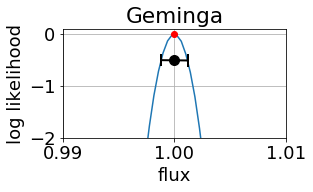

In [ ]:
cd.plot_concatenated(xlim=(0.99, 1.01), title=f'{cd.source.name}');
print('Parmeters from Poisson fit')
L = cd.full_likelihood()
pr = PoissonRep(L)
print(pd.Series(pr.info()))

In [ ]:
(cd.cells.n/cd.cells.e).describe()

count    656.00
mean       4.54
std        0.17
min        4.15
25%        4.44
50%        4.53
75%        4.63
max        6.68
dtype: float64

In [ ]:
show_doc(CellData)

<h2 id="CellData" class="doc_header"><code>class</code> <code>CellData</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>CellData</code>(**\*`pars`**, **\*\*`kwargs`**) :: [`SourceData`](/wtlikesource_data#SourceData)

Manage a set of cells generated from a data set

Invoke superclass to load photon data and exposure for the source.

* time_bins, default config.time_bins


Note that the `e`  cell entry is the actual exposure for the cell in units $cm^2\ s$, times $10^{-6}$.

In [ ]:
%nbdev_export
def concatenate_cells( cells):
    """
    Combine a group of cells to one
    - cells: dataframe with cells containing  n, w, S, B<br>
            Optionally, if $t$ is present, generate t and tw
    Return a dict with summed n, S, B, and concatenated w
    """
    newcell = dict()
    if 't' in cells:
        ca, cb =cells.iloc[0], cells.iloc[-1]
        newcell.update(dict(t= 0.5*(ca.t-ca.tw/2 + cb.t+cb.tw/2), tw=cb.t-ca.t ))

    for col in ' n S B'.split():
        newcell[col] = cells[col].sum()
    newcell['w'] = np.concatenate(list(cells.w.values))
    return newcell

In [ ]:
%nbdev_export
def partition_cells(config, cells, edges):
    """ Partition a set of cells
     - cells -- A DataFrame of cells
     - edges  -- a list of edge times delimiting boundaries between cells
     
    Returns a DataFrame of combined cells, with times and widths adjusted to account for missing cells
    
    """
    # get indices of  cell idexes just beyond each edge time
    ii = np.searchsorted(cells.t, edges)
    
    # Get the appropriate boundary times to apply to combined cells
    # this is complicated by missing cells, need to put boundary in gaps if ncessary
    ileft = ii[:-1]
    cleft = cells.iloc[ileft ]
    tleft =  (cleft.t - cleft.tw/2).values
    iright = ii[1:]-1
    cright = cells.iloc[iright ]  
    tright = (cright.t+cright.tw/2).values
    betweens = 0.5*(tleft[1:] + tright[:-1])
    tboundary = np.append(np.insert(betweens, 0, tleft[0]), tright[-1])
    
    # now combine the cells, 
    newcells = []
    for k in range(len(ii)-1):
        a,b = ii[k:k+2]
        subset = cells.iloc[a:b]; 

#         ca, cb = subset.iloc[0], subset.iloc[-1]
#         newcell = dict(t= 0.5*(ca.t-ca.tw/2 + cb.t+cb.tw/2)  )
        tl, tr = tboundary[k:k+2]
        newcell = dict(t=0.5*(tl+tr), tw=tr-tl)
        
        for col in 'e n S B'.split():
            newcell[col] = subset[col].sum()
        newcell['e'] /= len(subset)
        newcell['w'] = np.concatenate(list(subset.w.values)) #np.array(w, np.uint8)
        newcells.append(newcell)
    return pd.DataFrame(newcells)      

In [ ]:
show_doc(partition_cells)

<h4 id="partition_cells" class="doc_header"><code>partition_cells</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>partition_cells</code>(**`config`**, **`cells`**, **`edges`**)

Partition a set of cells
 - cells -- A DataFrame of cells
 - edges  -- a list of edge times delimiting boundaries between cells
 
Returns a DataFrame of combined cells, with times and widths adjusted to account for missing cells

In [ ]:
%nbdev_hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_weights.ipynb.
Converted 04_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10_simulation.ipynb.
Converted 14_bayesian.ipynb.
Converted index.ipynb.
Fri May  7 13:56:18 PDT 2021
